# A Fully-Connected, Binarized Network

In the previous section we successfully classified a single handwritten digit using a *binarized neural network*. Binarized Neural Networks (BNNs) are a subclass of QNNs, which use a single bit representing -1 or +1 for each weight and each activation. We will now go into more details of what happens inside such a network when we run an image through it.

Let's start by re-loading our neural network and our test image, so that they are readily available.

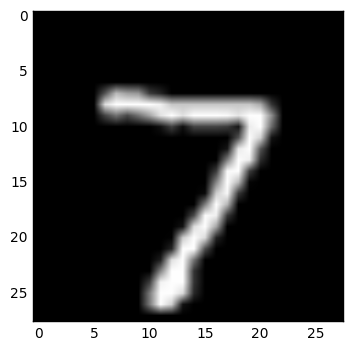

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load image using PIL
img = Image.open("7.png")
# convert to black and white
img = img.convert("L")
# convert to numpy array
img = np.asarray(img)
# display
% matplotlib inline
plt.imshow(img, cmap='gray')

from QNN.layers import *
import pickle
# load the qnn
qnn = pickle.load(open("mnist-w1a1.pickle", "rb"))
qnn

We will also define a little function **showSrc** to peek at the internals of the QNN module as follows:

In [43]:
import inspect

def showSrc(what):
    print("".join(inspect.getsourcelines(what)[0]))

## What's inside the predict function?

So what does the **predict** function we call look like on the inside? It actually just runs the QNN layer by layer. We pass the image as the input to the first layer, passing the output of each layer as the input of the next one, and return the output from the final layer like this:

In [44]:
showSrc(predict)

def predict(qnn, input_img):
  "Predict the class of input_img using a quantized neural network."
  activations = input_img
  for layer in qnn:
    activations = layer.execute(activations)
  return activations



## Activation Quantization: Thresholding Layers 
OK, so **predict** just calls the implementation for each layer -- but what's going on inside each layer? We can see that this network starts with a **BipolarThresholdingLayer**. A key component in all neural networks are nonlinearities introduced by [activation functions](https://en.wikipedia.org/wiki/Activation_function). There are many types of activation functions, but in the QNN models we will look at, most activations will be *thresholding layers*. What does thresholding mean? In this context, it means a function that has a number of pre-defined threshold values, and as output it returns how many of the thresholds were "crossed" (were smaller than) the input. To understand this a bit better, let's define a simple thresholding function with a single stair step and plot it:

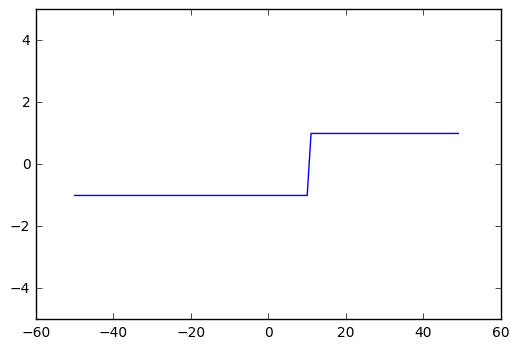

In [45]:
def simpleThreshold(x):
    if x <= 10:
        return -1
    else:
        return +1

x = range(-50,50)
y = map(simpleThreshold, x)
plt.plot(x, y)
plt.ylim([-5, 5])
plt.show()

We can see that the returned value is -1 for anything smaller than or equal to 10. When the threshold (10) is crossed, the value changes to +1. For our current BNN, the values returned by the threshold function will be either -1 or +1, which are representable by a single bit. To see this in action, we can run our image through just the first layer:

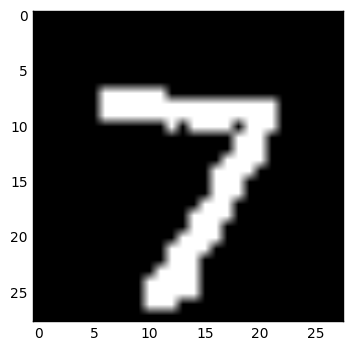

In [46]:
binarized_input = qnn[0].execute(img)
plt.imshow(binarized_input.reshape(28,28), cmap='gray')

So the quantizatiion essentially took away all the gray tones and turned it into a black-and-white image! Let's have a look at the internals of the QNNBipolarThresholdingLayer to see what's going in there.

In [47]:
showSrc(QNNBipolarThresholdingLayer)

class QNNBipolarThresholdingLayer(QNNThresholdingLayer):
    "A 1-level QNNThresholdingLayer that returns -1 and +1 instead of 0 and 1."
    def __init__(self, thresholds):
        super(QNNBipolarThresholdingLayer, self).__init__(thresholds)
        if self.thresholds.shape[0] != 1:
            raise Exception("BipolarThresholdingLayer can only have one level")

    def execute(self, v):
        # just the base implementation, but scaled by 2x-1 such that the output
        # is -1, +1 instead of 0, 1. this could have been done with a following
        # LinearLayer, but this way we keep the bipolar thresholding as a stand-
        # alone operation.
        ret = super(QNNBipolarThresholdingLayer, self).execute(v)
        return 2*ret - 1



Not much going on here -- it is derived from a base class QNNThresholdingLayer, and it just calls the execute function of that, multiplies the output by 2 and subtracts 1 to convert 0s and 1s to -1s and +1s. What does the base class implementation do, though?

In [48]:
showSrc(QNNThresholdingLayer)

class QNNThresholdingLayer(QNNLayer):
    "Given a set of thresholds, return the number of thresholds crossed."
    def __init__(self, thresholds):
        # we expect the thresholds array in the following format:
        # thresholds = [levels][channels]
        if thresholds.ndim == 1:
            self.thresholds = thresholds.reshape((len(thresholds),-1))
        elif thresholds.ndim == 2:
            self.thresholds = thresholds
        else:
            raise Exception("Thresholds array must be 1- or 2-dimensional")

    def execute(self, v):
        # interpret as multi-channel image, where the number of channels is
        # decided as the number of threshold channels
        vr = v.reshape((self.thresholds.shape[1], -1))
        ret = np.zeros(vr.shape, dtype=np.int)
        for t in self.thresholds:
            for c in range(self.thresholds.shape[1]):
                ret[c] += map(lambda x: 1 if x == True else 0, vr[c] >= t[c])
        return ret.flatten()



There's a bit of functional programming in there, but this is essentially a generalized version of the thresholding function we looked at. It allows specifying the thresholds (the x-coordinates of the stair step) as a list, though since our current network uses binarized activations, there will be only a single stair step -- we will look at the more general case in the next section. But also, when we are processing a vector of values instead of just a single value, it allows us to use different thresholds for each element of the vector (the second dimension of the thresholds parameter). 

So how do the thresholds look like for some of the QNNBipolarThresholdingLayers we have in the actual network?

In [49]:
print("First thresholding layer, parameter shape: " + str(qnn[0].thresholds.shape))
print("First thresholding layer, threshold values: \n" + str(qnn[0].thresholds))

First thresholding layer, parameter shape: (1, 1)
First thresholding layer, threshold values: 
[[34]]


In [50]:
print("Second thresholding layer, parameter shape: " + str(qnn[2].thresholds.shape))
print("Second thresholding layer, threshold values: \n" + str(qnn[2].thresholds))

Second thresholding layer, parameter shape: (1, 256)
Second thresholding layer, threshold values: 
[[   3    7   36  -36   36  -43   73    6  -19   10   -5  -34    8  -31
   -77   22    3  -29  -23   23   12   22  -39   61   23  -37  -53   -1
     2   17   28  -33  -29   -1   48  -19  -13   10  -11  -63   66   32
    -7   18  -60  -23  -23  -29  -52  -10  -52    0   -2    7   13   53
   -18   -7   -6   99   29    7   -8   97   15    0   62  -23  -25  -33
   -53  -31   -1  -54    0   77  -26   39   35   41   22   -5   21  -37
     1   10   10   59    3 -119  -12  -39   25    5   80  -41  -47  -10
   -23  -37   43  -32   29  -23   13    7  -41   24   58   29   18  -62
    -9  -23  -48  -16  -10   31  -39    0   -4  -15  -30   46   33  -51
   -41    8  -28  -28  -10    6   28   36   27  -11   13  -85   18   28
    43  -36   36  -10  -49   20  -70  -22  -12   54  -12  -43  -53  -45
   -46   47   -8   69  -68   25   78    1  -48   19    2   26  -25   27
   -55   13   40   -5  -12  -30   10 

Here we can see that the first thresholding layer, which simply quantizes the input image, uses the same threshold value for all the pixels. The second thresholding layer receives a vector of 256 elements, and uses a different threshold value for each of them. Where do these thresholds come from? As you may have guessed, they are a product of the neural network training process, so you don't have to worry about that in this tutorial -- they are just magic numbers :-)

## Fully Connected Layers
What else is in our network besides thresholding? There are a total of 4 QNNFullyConnectedLayer instances, so let's have a look at that next. Such a Fully Connected (FC) layer uses a different *weight* for each element in its input vector, creating a *weighted sum* based on the input. They actually created multiple weighted sums using different weights, so their operation actually just corresponds to matrix-vector multiplication. We can see this in their implementation:

In [51]:
showSrc(QNNFullyConnectedLayer)

class QNNFullyConnectedLayer(QNNLayer):
    """
    Fully-connected network layers as matrix-vector multiplication.
    Note that bias is not implemented, this can be done by adding a LinearLayer
    with A=1 B=bias following the QNNFullyConnectedLayer.
    """
    def __init__(self, W):
        self.W = W

    def execute(self, v):
        return np.dot(self.W, v)



There's actually nothing else in there -- just a call to the numpy dot product function. What about **self.W**, which contains the weight matrix? What does that look like?

In [52]:
print("First FC layer weight matrix shape: " + str(qnn[1].W.shape))
qnn[1].W

First FC layer weight matrix shape: (256, 784)


array([[-1, -1, -1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       [ 1,  1, -1, ..., -1,  1,  1],
       ..., 
       [ 1,  1, -1, ...,  1,  1,  1],
       [ 1, -1,  1, ..., -1,  1, -1],
       [-1, -1, -1, ...,  1, -1, -1]], dtype=int8)

It also only contains -1 and +1 values, which come from the neural network training process (so again, *magic*). Since this is a 256x784 matrix, it will take in a 784-dimensional vector (so, a 28x28 image) and emit a 256-dimensional vector (not necessarily recognizable as an image anymore since it contains weighted sums of different pixels). What do the outputs look like? We can check that by running the image through the first two layers of our network:

In [53]:
fc_0_output = predict(qnn[0:2], img)
print("First FC layer output shape: " + str(fc_0_output.shape))
fc_0_output

First FC layer output shape: (256,)


array([   6,  -12,   90,  -84,   16,  -62,  128,  -52,  -58,    8,   32,
        -18,  -36,  -48,  -54,    4,   -4,  -44,  -34,   38,   10,   10,
         10,   74,  -28,   -6,  -92,   22,  -18,   10,   26,    8,   10,
         12,   38,  -26,  -26,   -8,   14,  -62,   94,    0,   50,   38,
        -42,   12,  -56,    2,    8,  -74,  -34,  -42,   32,  -14,   90,
         54,   36,  -10,  -52,   48,  -34,   52,  -36,   32,   66,   44,
        116,   50,  -18,   -6,  -12,   14,  -62,    0,   20,   78,   18,
         16,   18,   30,   54,  -34,   36, -104,   -8,  -24,   -6,   34,
        -12, -106,   30,   -2,  -30,    0,    6,  -58, -104,   -6,   42,
        -84,   46,   24,    0,  -32,  -48,   60,  -24,   28,   52,   56,
         46,   14,   36,   -2,  -20,   -4,  -44,   52,   22,   -6,   30,
         -2,   -4,   32,   72,  -34,  -46,   44,    0,  -50,   -6,   48,
         42,   18,   46,  -52,  -28,  -90,   -6,    0,   68,  -80,  -24,
         44,  -40,   34, -110,   14,   16,    8,  -

As you can see, even just passing through the first FC layer, the output are no longer easy to interpret for a human. This is why deep neural networks are sometimes referred to as [black boxes](http://www.sciencemag.org/news/2017/07/how-ai-detectives-are-cracking-open-black-box-deep-learning), although I chose to call them "gray boxes" in this tutorial. We can see exactly what kind of computation (matrix-vector, threshold...) is going on inside, and which numbers are passing through the layers, but it's not so easy to *make sense of* those numbers.

> **Aside: XNOR-popcount for binarized networks.** Since we know that the input to this fully-connected layer is also going to be a vector of only -1 and +1 values, we can actually make an interesting observation: if we were to represent -1 values with a 0 bit and +1 values with a 1 bit, we could compute the entire matrix-vector product using binary [XNOR](https://en.wikipedia.org/wiki/XNOR_gate) and (popcount)[https://en.wikipedia.org/wiki/Hamming_weight] operations. Since popcount only adds up the resulting +1 values, you'll have to adjust the resulting sum  to account for the -1 values as well, but this is still vastly simpler than computing everything in floating point numbers as we are doing here with numpy. This XNOR-popcount technique has been applied on [FPGAs](https://arxiv.org/abs/1612.07119), [CPUs](https://arxiv.org/abs/1705.09864) and [GPUs](https://arxiv.org/pdf/1705.07175.pdf) to deploy BNNs with very high performance.

## A Pattern Starts to Emerge
Putting together what we've learned so far, we can make out what is going on in most of this network, since it's just thresholding and FC layers one after another:

In [54]:
qnn[0:8]


1. The qnn[0] QNNBipolarThresholdingLayer binarizes our input image
2. The qnn[1] QNNFullyConnectedLayer creates linear combinations of its input
3. The qnn[2] QNNBipolarThresholdingLayer binarizes its inputs produced by the FC layer
4. The qnn[3] QNNFullyConnectedLayer creates linear combinations of its input

...and so on. Most deep neural networks today contain repeating patterns of layers like this. How do we know what kind of patterns and layers to put together? Again, that's a bit of black magic that is outside the scope of this tutorial, but you can read more about that [here](http://cs231n.github.io/convolutional-networks/#layerpat) if you want to know more.

## The Final Pieces: Scaling and Softmax
We're actually almost done going through our network. The two final layers are QNNScaleShiftLayer and QNNSoftmaxLayer, which are also relatively simple layers that are commonly found at the end of QNNs. Let's start with having a look at what the QNNScaleShiftLayer does:

In [55]:
showSrc(QNNScaleShiftLayer)

class QNNScaleShiftLayer(QNNLayer):
    "Using 1D vectors A and B, apply Ax+B to incoming x."
    def __init__(self, A, B):
        if A.shape != B.shape:
            raise Exception("QNNScaleShiftLayer A and B shapes do not match")
        if A.ndim != 1:
            raise Exception("QNNScaleShiftLayer needs 1D vectors as parameters.")
        self.A = A
        self.B = B

    def execute(self, v):
        # the outermost dimension is the channel dimension
        # reshape as inner dimension to apply transform
        vr = v.reshape((self.A.shape[0], -1)).transpose()
        return (self.A*vr+self.B).transpose().flatten()



The reshape and transpose in the **execute()** function may look a bit scary, but all this layer is doing is actually multiplying (scaling) its input by a vector **A**, then adding (shifting) this by a vector **B**. **A** and **B** are supposed to be 1-dimensional vectors, as you can see in the initializer. The transpose and reshape operations are done to make sure the scaling is applied along the channels dimension, that is, each element of the incoming input vector is scaled with a different number for a fully-connected layer. This will be a little different further on for convolutional neural networks, but we will come to that later on.

To make things a little more concrete, let's have a look at the **A** and **B** of our QNNScaleShiftLayer:

In [56]:
print("Scale: " + str(qnn[8].A))
print("Shift: " + str(qnn[8].B))

Scale: [ 0.04175314  0.03991559  0.04339832  0.04174238  0.04294065  0.0413337
  0.04307769  0.04429524  0.04124721  0.04182861]
Shift: [-0.08773118 -0.06955352  0.04392026  0.07091018 -0.03852779  0.0639951
 -0.07374354 -0.02511922  0.11293755  0.00291254]


Once again, you can treat these as magic numbers coming from the training process. What's different from all the other magic numbers we have looked at so far is that these are *floating point numbers* as opposed to just -1 and +1. As this layer constitutes a very small part of the overall computation, this isn't a big deal for performance -- the vast majority of operations in our QNN are still quantized operations.

Finally, let's have a look at the softmax layer. It computes something called the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) on the network output, and its source code looks like this:

In [57]:
showSrc(QNNSoftmaxLayer)

class QNNSoftmaxLayer(QNNLayer):
    "Compute softmax values for each sets of scores."
    def execute(selv, v):
        e_x = np.exp(v - np.max(v))
        return e_x / e_x.sum()



What this essentially does is to transform the vector of output numbers so that they sum up to 1 while keeping the small numbers small and big numbers big, allowing us to interpret the softmax output as probabilities. In fact, you could take away the softmax layer and take the maximum of the output of the last layer directly, and you would still get a correct classification result by looking at the maximum value:

In [58]:
ret_no_softmax = predict(qnn[:8], img)
print("Last layer outupts without softmax: " + str(ret_no_softmax))
print("Predicted class: %d" % np.argmax(ret_no_softmax))

Last layer outupts without softmax: [  2 -22 -14 -12  -4 -44 -68 196 -94  40]
Predicted class: 7


As you can see the predicted class is still the same since the index that has the maximum value does not change, but it's no longer easy to reason about how to interpret the *values* of those numbers.

And that's it! We have now looked at what kind of computation takes place in this network every step of the way. It is somewhat fascinating that one can classify images by multiply-adding -1 and +1 values and comparing them against some thresholds, but that's the magic of binarized neural networks for you. In the next section we'll be looking at essentially the same network but using 2-bit activations instead of binarized ones.